<a href="https://colab.research.google.com/github/Denchil-RPG/Machine/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка естественного языка (NLP)

In [ ]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import warnings
warnings.filterwarnings('ignore')

# Загружаем датасет

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url = '/content/drive/MyDrive/Colab Notebooks/data/Tweets.csv'

In [ ]:
# Загружаем данные из датасета
questions = pd.read_csv(url,encoding='utf-8')
# Выводим первые 5 строк
questions.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [ ]:
# Выводим последние 5 строк
questions.tail()

textID                                               text  \
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  
27476                                             d lost  negative  
27477                                      , don`t force  negative  
27478                          Yay good for both of you.  positive  
27479                         But it was worth it  ****.  positive  
27480  All this flirting going on - The ATG smiles. Y...   neutral

In [ ]:
questions.describe()

textID                                  text selected_text  \
count        27481                                 27480         27480   
unique       27481                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27481  
unique         3  
top      neutral  
freq       11118

# Предобработка данных

Воспользуемся регулярными выражениями, чтобы очистить данные и сохранить их на диск для будущего использования.

In [ ]:
def standardize_text(df, text_field):
    # Удаляем url адреса
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    # Удаляем упоминания пользователей
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    # Удаляем все символы, кроме перечисленных
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    # Переводит текст в нижний регистр
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

# Сохраняем в csv файл
questions.to_csv("clean_data.csv")
questions.head()

textID                                               text  \
0  cb774db0d1                i`d have responded, if i were going   
1  549e992a42      sooo sad i will miss you here in san diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [ ]:
# Удаляем добавившийся столбец
clean_questions = pd.read_csv("clean_data.csv").drop('Unnamed: 0', axis=1)
clean_questions.tail()

textID                                               text  \
27476  4eac33d1c0   wish we could come see u on denver  husband l...   
27477  4f4c4fc327   i`ve wondered about rake to.  the client has ...   
27478  f67aae2310   yay good for both of you. enjoy the break - y...   
27479  ed167662a5                         but it was worth it  ****.   
27480  6f7127d9d7     all this flirting going on - the atg smiles...   

                                           selected_text sentiment  
27476                                             d lost  negative  
27477                                      , don`t force  negative  
27478                          Yay good for both of you.  positive  
27479                         But it was worth it  ****.  positive  
27480  All this flirting going on - The ATG smiles. Y...   neutral

## Анализ датасета

Посмотрим на распределение по классам

In [ ]:
# Посмотрим на распределение по классам
clean_questions.groupby("sentiment").count()

textID   text  selected_text
sentiment                              
negative     7781   7781           7781
neutral     11118  11117          11117
positive     8582   8582           8582

Данные сбалансированные

In [ ]:
# Твиты, которые мы будем анализировать
clean_questions["text"]

0                      i`d have responded, if i were going
1            sooo sad i will miss you here in san diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4         sons of ****, why couldn`t they put them on t...
                               ...                        
27476     wish we could come see u on denver  husband l...
27477     i`ve wondered about rake to.  the client has ...
27478     yay good for both of you. enjoy the break - y...
27479                           but it was worth it  ****.
27480       all this flirting going on - the atg smiles...
Name: text, Length: 27481, dtype: object

In [ ]:
# Преобразуем категориальный тип целевой переменной в int
clean_questions['text'] = clean_questions['text'].astype(str)
clean_questions["sentiment"] = clean_questions["sentiment"].astype('category')
clean_questions["sentiment"] = clean_questions["sentiment"].cat.codes

In [ ]:
clean_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27481 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  int8  
dtypes: int8(1), object(3)
memory usage: 671.0+ KB


In [ ]:
clean_questions

textID                                               text  \
0      cb774db0d1                i`d have responded, if i were going   
1      549e992a42      sooo sad i will miss you here in san diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on denver  husband l...   
27477  4f4c4fc327   i`ve wondered about rake to.  the client has ...   
27478  f67aae2310   yay good for both of you. enjoy the break - y...   
27479  ed167662a5                         but it was worth it  ****.   
27480  6f7127d9d7     all this flirting going on - the atg smiles...   

                                           selected_text  sentiment  
0                    I`d have responded, if I were going          1  
1                                               Sooo SAD          0  
2                                            bullying me          0  
3                                         leave me alone          0  
4                                          Sons of ****,          0  
...                                                  ...        ...  
27476                                             d lost          0  
27477                                      , don`t force          0  
27478                          Yay good for both of you.          2  
27479                         But it was worth it  ****.          2  
27480  All this flirting going on - The ATG smiles. Y...          1  

[27481 rows x 4 columns]

Теперь мы перешли к целочисленным значениям целевой переменной:

0 - negative

1 - neutral

2 - positive

Нарисуем карту слов

 i`d have responded, if i were going  sooo sad i will miss you here in san diego!!! my boss is bullying me...  what interview! leave me alone  sons of ****, why couldn`t they put them on the releases we already bought ://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth 2am feedings for the baby are fun when he is all smiles and coos soooo high  both of you  journey!? wow... u just became cooler.  hehe... (is that possible!?)  as much as i love to be hopeful, i reckon the chances are minimal =p i`m never gonna get my cake and stuff i really really like the song love story by taylor swift my sharpie is running dangerously low on ink i want to go to music tonight but i lost my voice. test test from the lg env2 uh oh, i am sunburned  s`ok, trying to plot alternatives as we speak *sigh* i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on it would look... ://tinyurl.com/mnf4kw is back home now      gonna miss eve

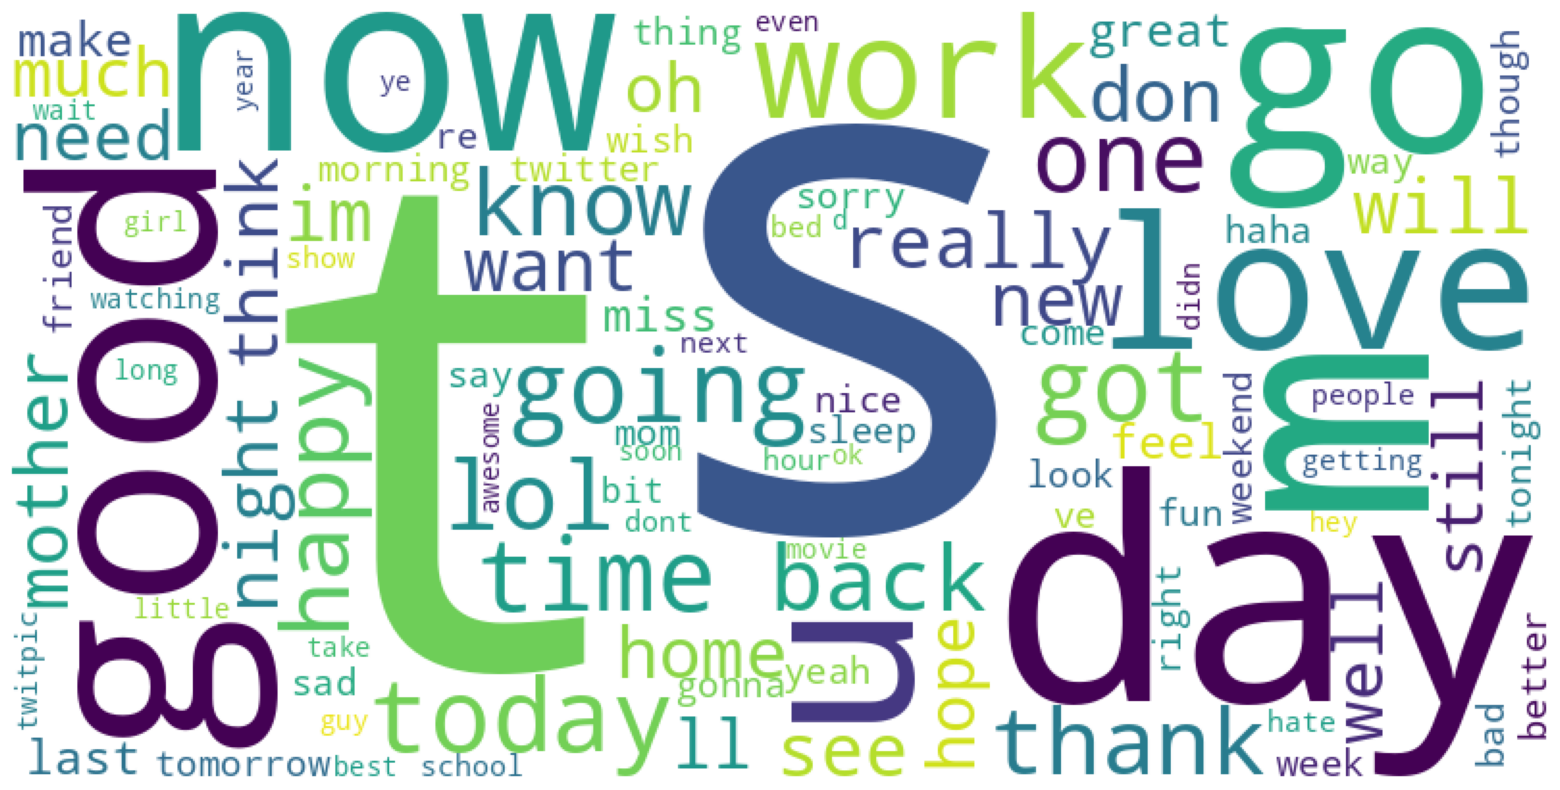

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Объединяем твиты в один текст
a = " ".join(clean_questions["text"])
print(a)

# Строим облако слов
en_cloud = WordCloud(max_words=100, background_color='white',
                     width=800, height=400,
                     collocations=False).generate(a)
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(en_cloud)

# Подготовка данных

In [ ]:
from nltk.tokenize import RegexpTokenizer

# Создаём токенизатор
tokenizer = RegexpTokenizer(r'\w+')

# Токенизируем каждый твит
clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

textID                                               text  \
0  cb774db0d1                i`d have responded, if i were going   
1  549e992a42      sooo sad i will miss you here in san diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text  sentiment  \
0  I`d have responded, if I were going          1   
1                             Sooo SAD          0   
2                          bullying me          0   
3                       leave me alone          0   
4                        Sons of ****,          0   

                                              tokens  
0        [i, d, have, responded, if, i, were, going]  
1  [sooo, sad, i, will, miss, you, here, in, san,...  
2                       [my, boss, is, bullying, me]  
3                [what, interview, leave, me, alone]  
4  [sons, of, why, couldn, t, they, put, them, on...

## Анализируем списки токенов

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from  keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Список всех токенов
all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
# Длины токенов в каждом твите
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
# Уникальные токены
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

367557 words total, with a vocabulary size of 26477
Max sentence length is 39


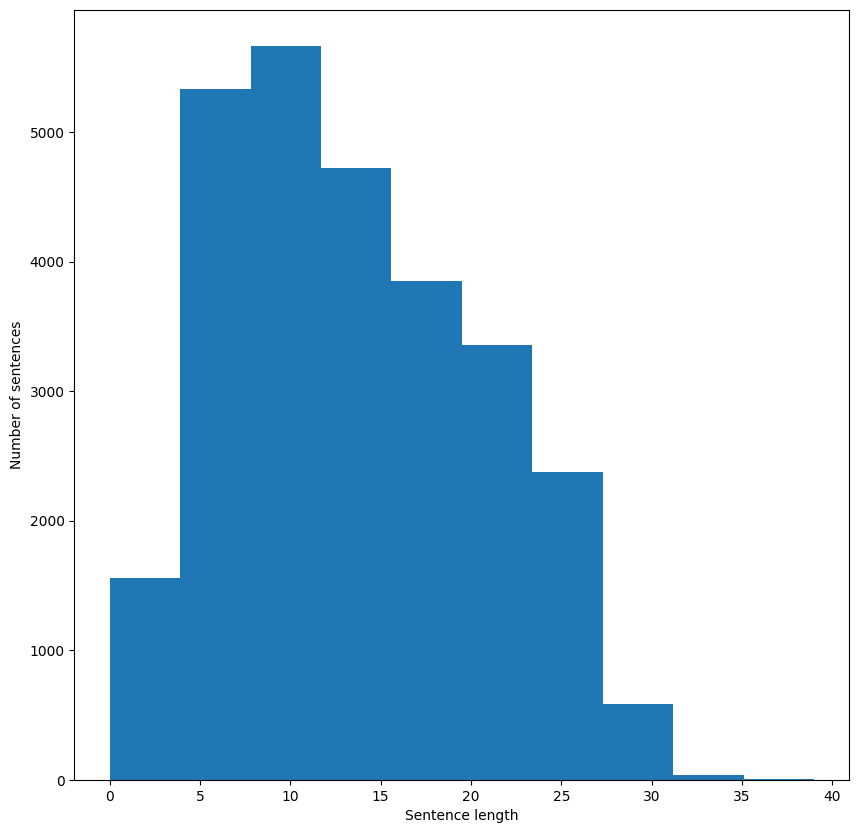

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

# Модель: Мешок слов (Bag of Words Counts)

**Мешок слов** - мы можем построить словарь всех уникальных слов в нашем датасете, и ассоциировать уникальный индекс каждому слову в словаре. Каждое предложение тогда можно будет отобразить списком, длина которого равна числу уникальных слов в нашем словаре, а в каждом индексе в этом списке будет хранится, сколько раз данное слово встречается в предложении.
То есть мешок слов просто связывает индекс с каждым словом в нашем словаре и встраивает каждое предложение в виде списка нулей, с 1 в каждом индексе, соответствующем слову, присутствующему в предложении.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Преобразует текстовые данные в матрицу векторов
def cv(data):
    count_vectorizer = CountVectorizer() # Мешок слов
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

# Список текстов
list_corpus = clean_questions["text"].tolist()
# Список значений класса
list_labels = clean_questions["sentiment"].tolist()

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=12)
# преобразования выборок в матрицы
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

## Визуализируем векторные представления

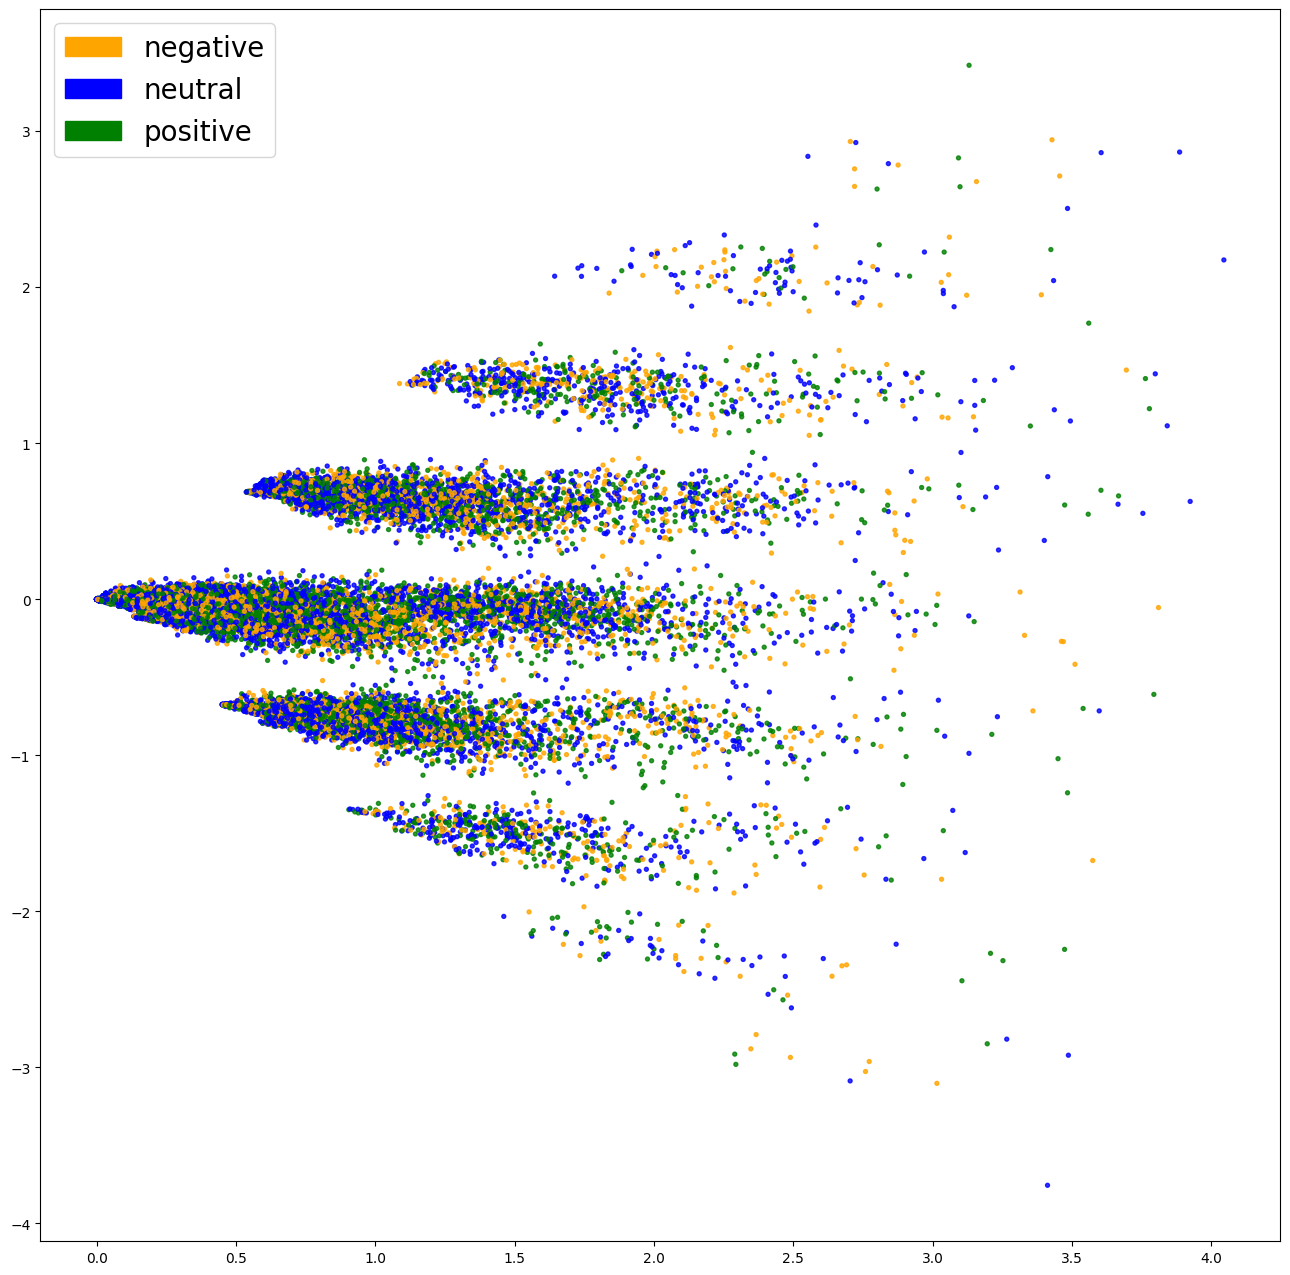

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','green']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=color_column, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='negative')
            blue_patch = mpatches.Patch(color='blue', label='neutral')
            green_patch = mpatches.Patch(color='green', label='positive')
            plt.legend(handles=[red_patch, blue_patch, green_patch], prop={'size': 20})

# Посмотрим, можно ли разделить данные
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

Не получилось разделить на классы

## Классификация


In [ ]:
from sklearn.linear_model import LogisticRegression

# Создаём модель
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=12)
# Обучаем
clf.fit(X_train_counts, y_train)

# Предсказываем значения
y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Выбираем наилучшие параметры
param_grid = {
    'C': [0.1, 1, 10, 30],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'multi_class': ['ovr', 'multinomial']
}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=12), param_grid, cv=5)
grid.fit(X_train_counts, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 1, 'multi_class': 'ovr', 'solver': 'liblinear'}


In [ ]:
from sklearn.linear_model import LogisticRegression

# Создаём модель
clf = LogisticRegression(C=1, class_weight='balanced', solver='liblinear',
                         multi_class='ovr', n_jobs=-1, random_state=12)
# Обучаем
clf.fit(X_train_counts, y_train)

# Предсказываем значения
y_predicted_counts = clf.predict(X_test_counts)

## Метрики


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score, classification_report

def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    r2 = r2_score(y_test, y_predicted)
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1, r2

# Выводим метрики
accuracy, precision, recall, f1, r2 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy, precision, recall, f1,r2))

accuracy = 0.704, precision = 0.705, recall = 0.704, f1 = 0.704, r2 = 0.331


Получились не самые плохие метрики

## Матрица ошибок

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    # Возможность нормализации матрицы для несбалансированных классов
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Отображение матрицы
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    # Настройка осей
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    # Подписи внутри матрицы
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    # Подписи осей
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

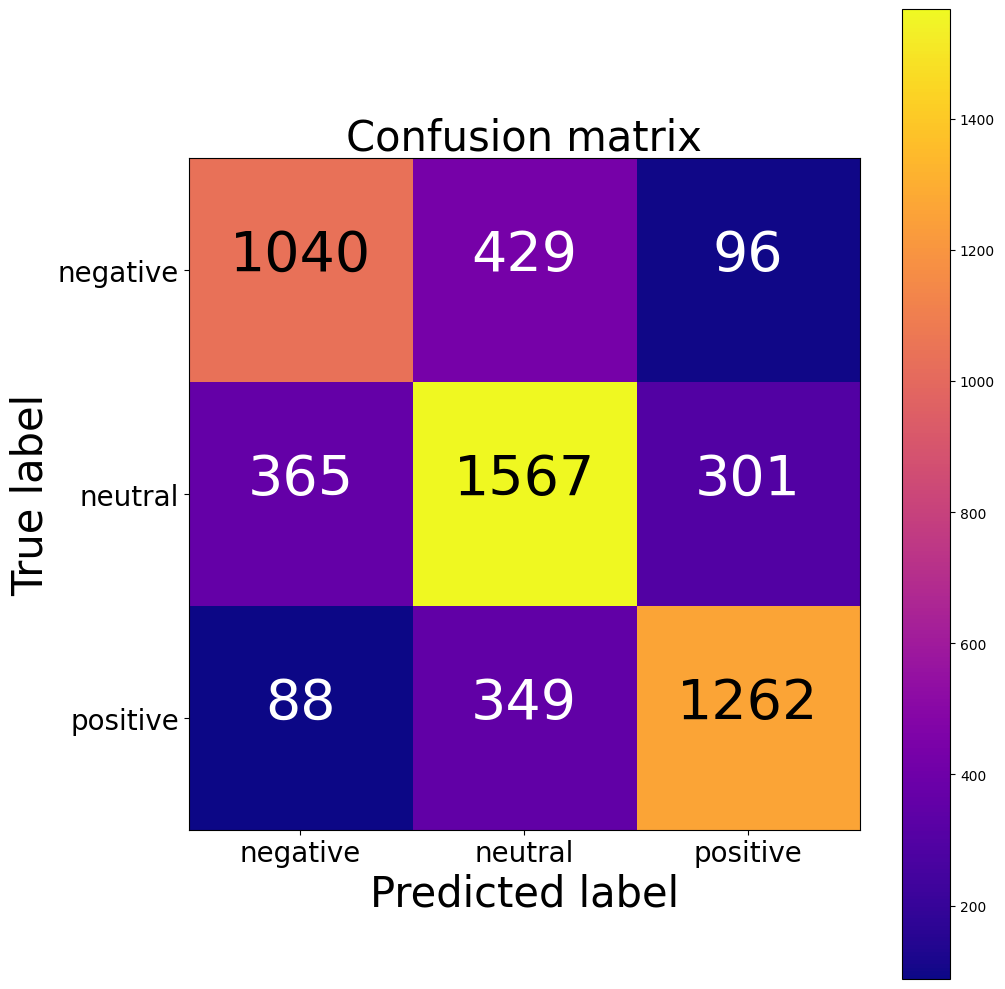

[[1040  429   96]
 [ 365 1567  301]
 [  88  349 1262]]


In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts) # Матрица ошибок
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['negative','neutral','positive'], normalize=False, title='Confusion matrix', cmap="plasma")
plt.show()
print(cm)

Наш классификатор хорошо отличает положительный окрас текста от отрицательного

## Посмотрим, на что опирается наша модель

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    # Словарь, в котором индексы - слова, ключи - индексы в матрице
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        # Извлечение наиболее важных признаков (важность, признак)
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        # Сортировка признаков
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        # n наиболее важных признаков
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        # n наименее важных признаков
        bottom = sorted_coeff[-n:]
        # Сохранение результатов
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [ ]:
importance

{0: {'tops': [(2.6154520411703115, 'boring'),
   (2.6264362311512635, 'miss'),
   (2.657046797675696, 'hate'),
   (2.7261652988753515, 'stupid'),
   (2.761209072264812, 'fail'),
   (2.7761323286725585, 'headache'),
   (2.8866743286234255, 'hates'),
   (2.9436714375164104, 'worst'),
   (3.029681936901976, 'sad'),
   (3.3240223398597224, 'sucks')],
  'bottom': [(-2.0166501313088716, 'loved'),
   (-2.0179094710202214, 'amazing'),
   (-2.1342816988026954, 'thank'),
   (-2.1417003819398017, 'welcome'),
   (-2.510603490846377, 'cute'),
   (-2.527048482795612, 'love'),
   (-2.5347347928153385, 'awesome'),
   (-2.602907584640969, 'thanks'),
   (-2.8128917831098272, 'hopefully'),
   (-3.097610118717865, 'glad')]},
 1: {'tops': [(1.3148586004371434, 'twhirl'),
   (1.3283870677240532, 'blond'),
   (1.359748923821586, 'starwarsday'),
   (1.3649371740067158, 'whether'),
   (1.3658334920380275, '2moro'),
   (1.4277605744591972, 'jst'),
   (1.4348376417563775, 'hummmmm'),
   (1.4692428221955383, 'maï

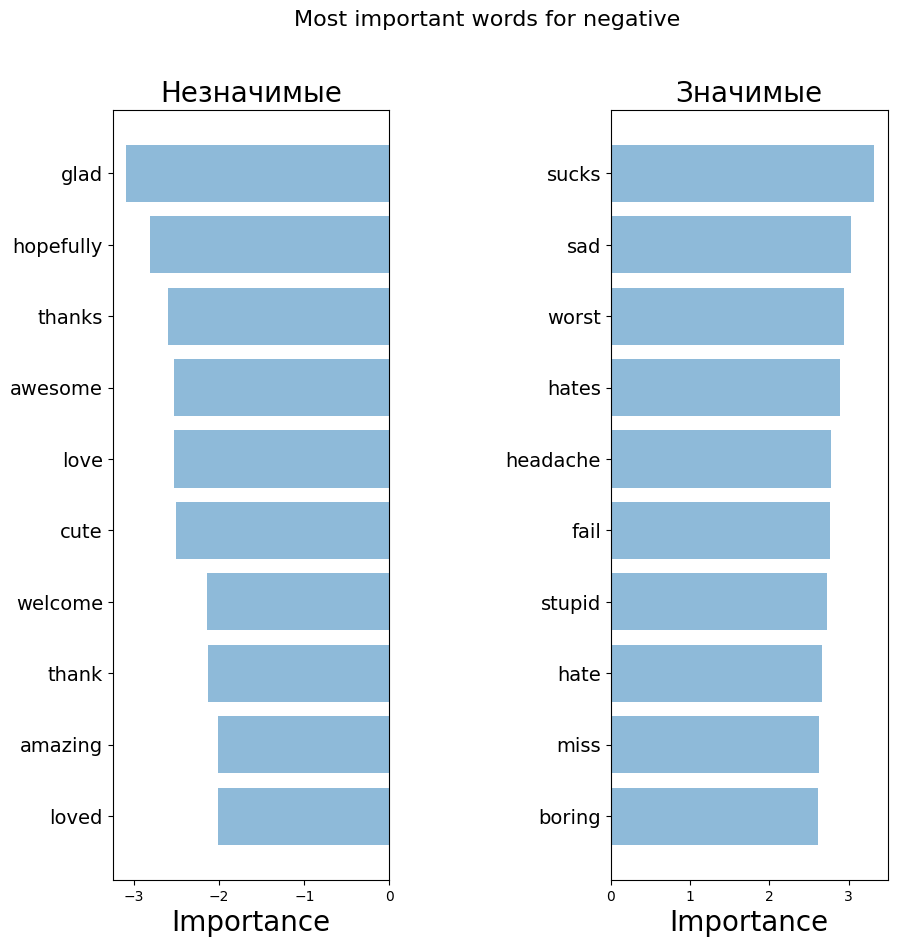

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    # Положение слов
    y_pos = np.arange(len(top_words))

    # Создание пар слово важность и их сортировка
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    # Извлекаем наиболее важные/неважные
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Незначимые', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Значимые', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

# Для negative
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for negative")

Наш классификатор верно нашел достаточное количество слов, которые придают тексту негативный окрас (hate, sad, fail, sad, sucks...)

# Модель: TFIDF Bag of Words

Чтобы помочь нашей модели сфокусироваться на значимых словах, мы можем использовать скоринг TF-IDF (Term Frequency, Inverse Document Frequency) поверх нашей модели «мешка слов». TF-IDF взвешивает на основании того, насколько они редки в нашем датасете, понижая в приоритете слова, которые встречаются слишком часто и просто добавляют шум. Ниже приводится проекция метода главных компонент, позволяющая оценить наше новое представление.

## Визуализируем векторные представления

In [ ]:
# Модель учитывает частоту и меру значимости
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

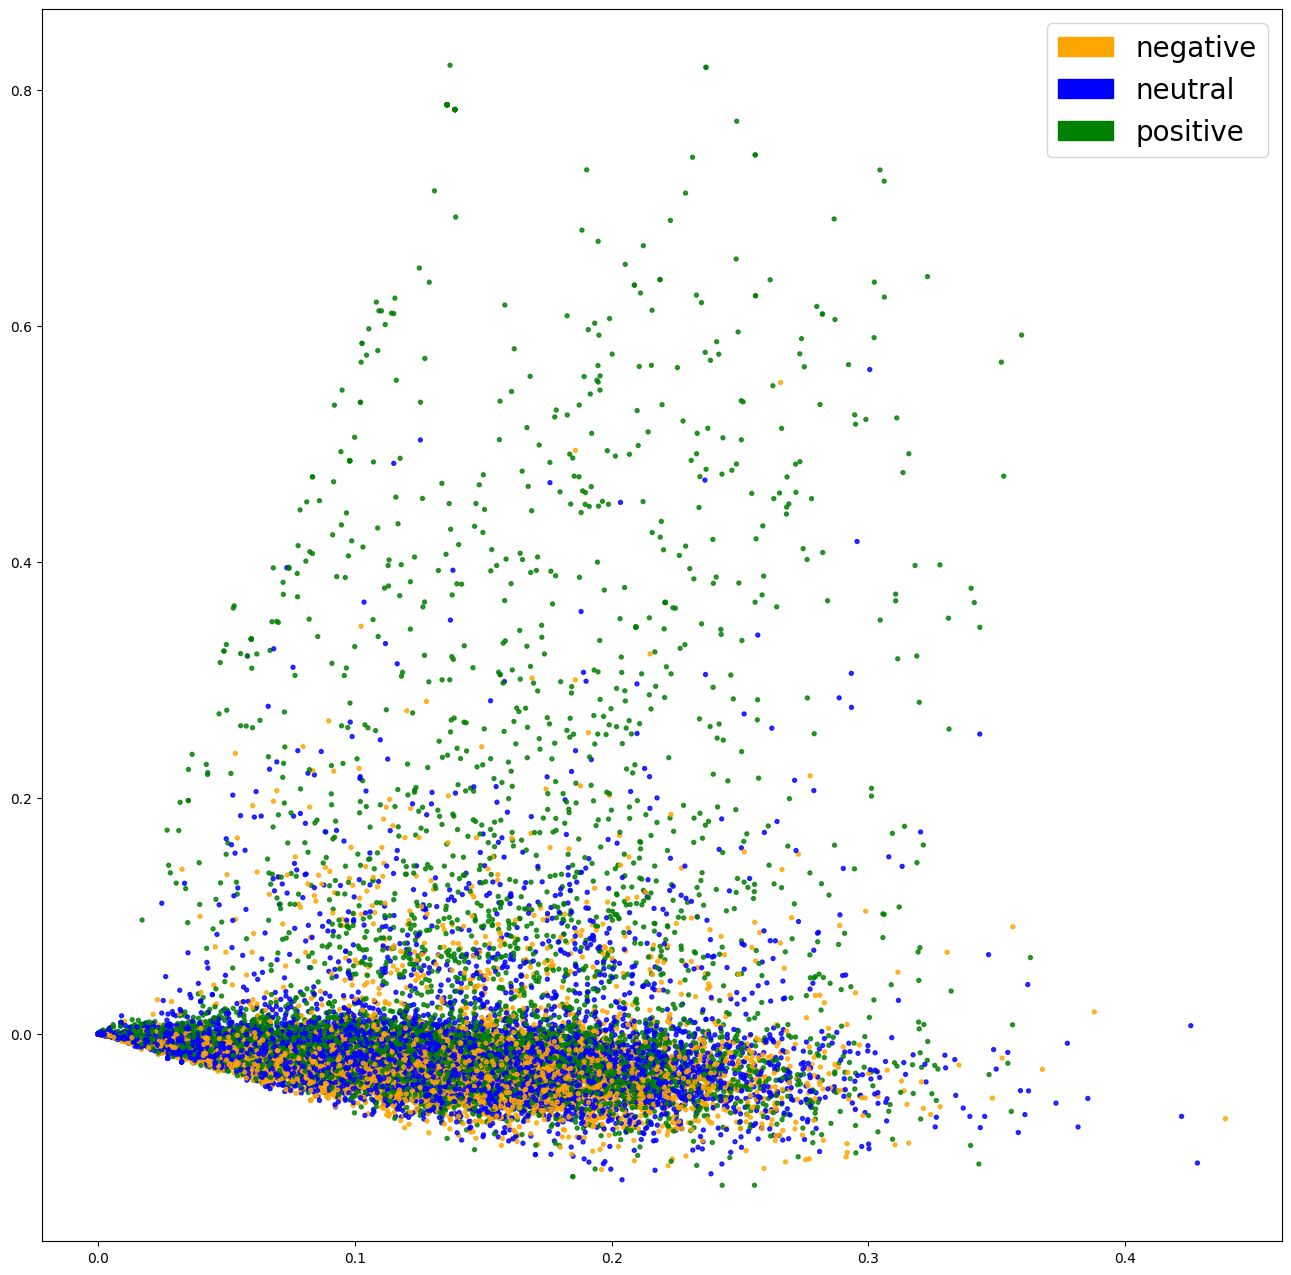

In [ ]:
# Строим график при помощи латентного семантического анализа
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plt.show()

Не получилось разделить на классы

## Классификация

In [ ]:
from sklearn.model_selection import GridSearchCV

# Выбираем наилучшие параметры
param_grid = {
    'C': [0.1, 1, 10, 30],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'multi_class': ['ovr', 'multinomial']
}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=12), param_grid, cv=5)
grid.fit(X_train_tfidf, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 1, 'multi_class': 'ovr', 'solver': 'liblinear'}


In [ ]:
# Также строим модель
clf_tfidf = LogisticRegression(C=1, class_weight='balanced', solver='liblinear',
                         multi_class='ovr', n_jobs=-1, random_state=12)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

## Метрики

In [ ]:
# Выводим значения метрик
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f"  % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf))


accuracy = 0.700, precision = 0.701, recall = 0.700, f1 = 0.700, r2 = 0.337


Метрики получились точно такими же

## Матрица ошибок

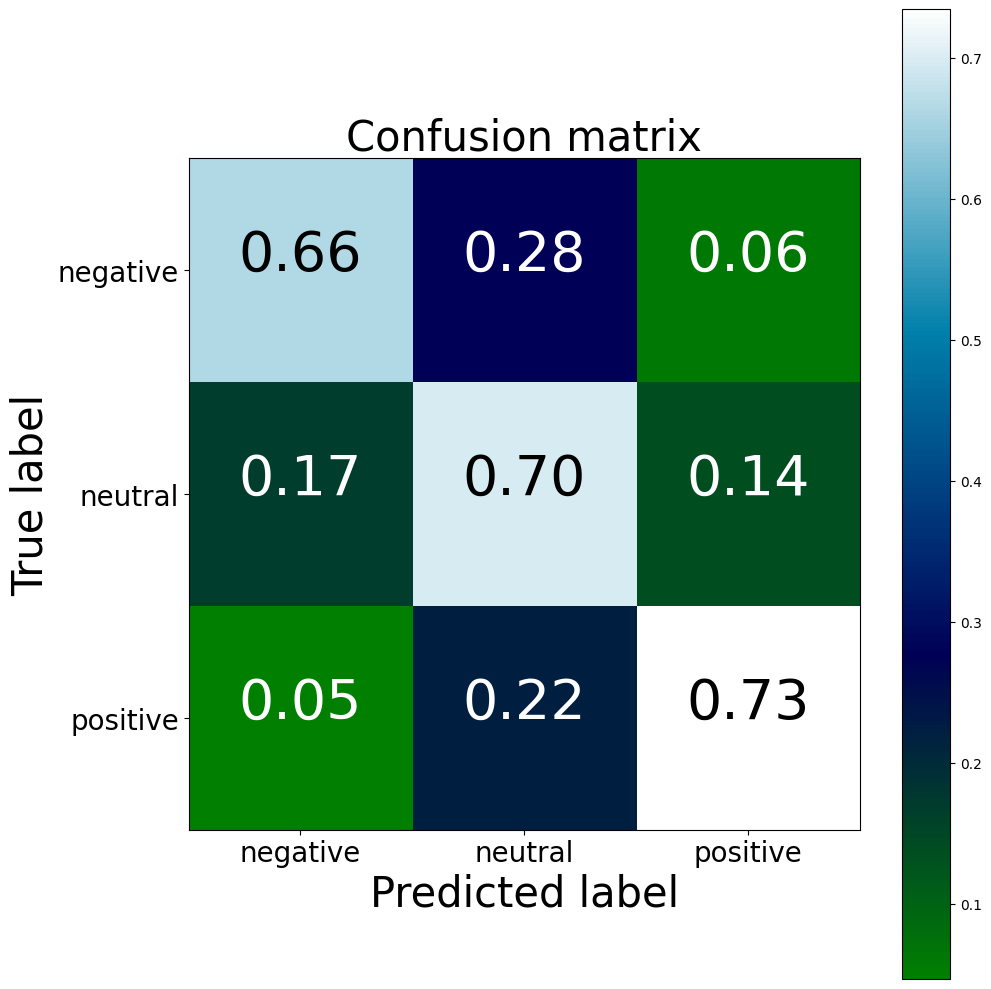

TFIDF confusion matrix
[[1039  435   91]
 [ 370 1559  304]
 [  79  372 1248]]
BoW confusion matrix
[[1040  429   96]
 [ 365 1567  301]
 [  88  349 1262]]


In [ ]:
# Матрица ошибок
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['negative','neutral','positive'], normalize=True, title='Confusion matrix', cmap="ocean")
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Сравним две матрицы: видим, что они практически идентичны

## Посмотрим, на что опирается наша модель

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

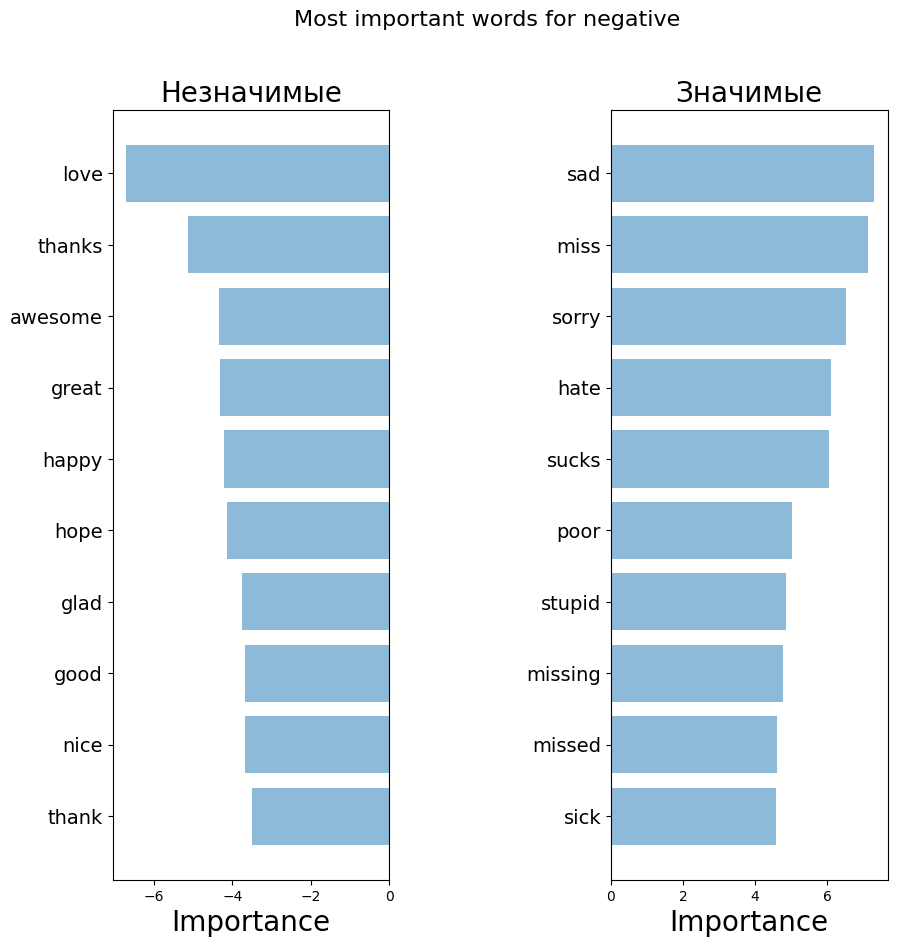

In [ ]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for negative")

Выбранные моделью слова достаточно похожи на слова, которые выбрала предыдущая модель.

Это может означать, что редко используемые слова не так кважны для классификации.

# Модель: Word2Vec

Word2Vec — это техника для поиска непрерывных отображений для слов. Word2Vec обучается на прочтении огромного количества текста с последующим запоминанием того, какое слово возникает в схожих контекстах. После обучения на достаточном количестве данных, Word2Vec генерирует вектор из 300 измерений для каждого слова в словаре, в котором слова со схожим значением располагаются ближе друг к другу.

## Загружаем обученную модель

In [ ]:
# Загружаем обученную модель
!python -m gensim.downloader --download word2vec-google-news-300

2024-11-24 18:41:11,435 : __main__ : INFO : Data has been installed and data path is /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    # Вычисление векторного представления текста
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# Создание векторного представления (эмбендинга) для всех токенов в датасете
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

## Разделение на выборки для классификации

In [ ]:
# Получаем датасет, состоящий из эмбендингов
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,
                                                                                        test_size=0.2, random_state=12)

## Визуализируем векторные представления

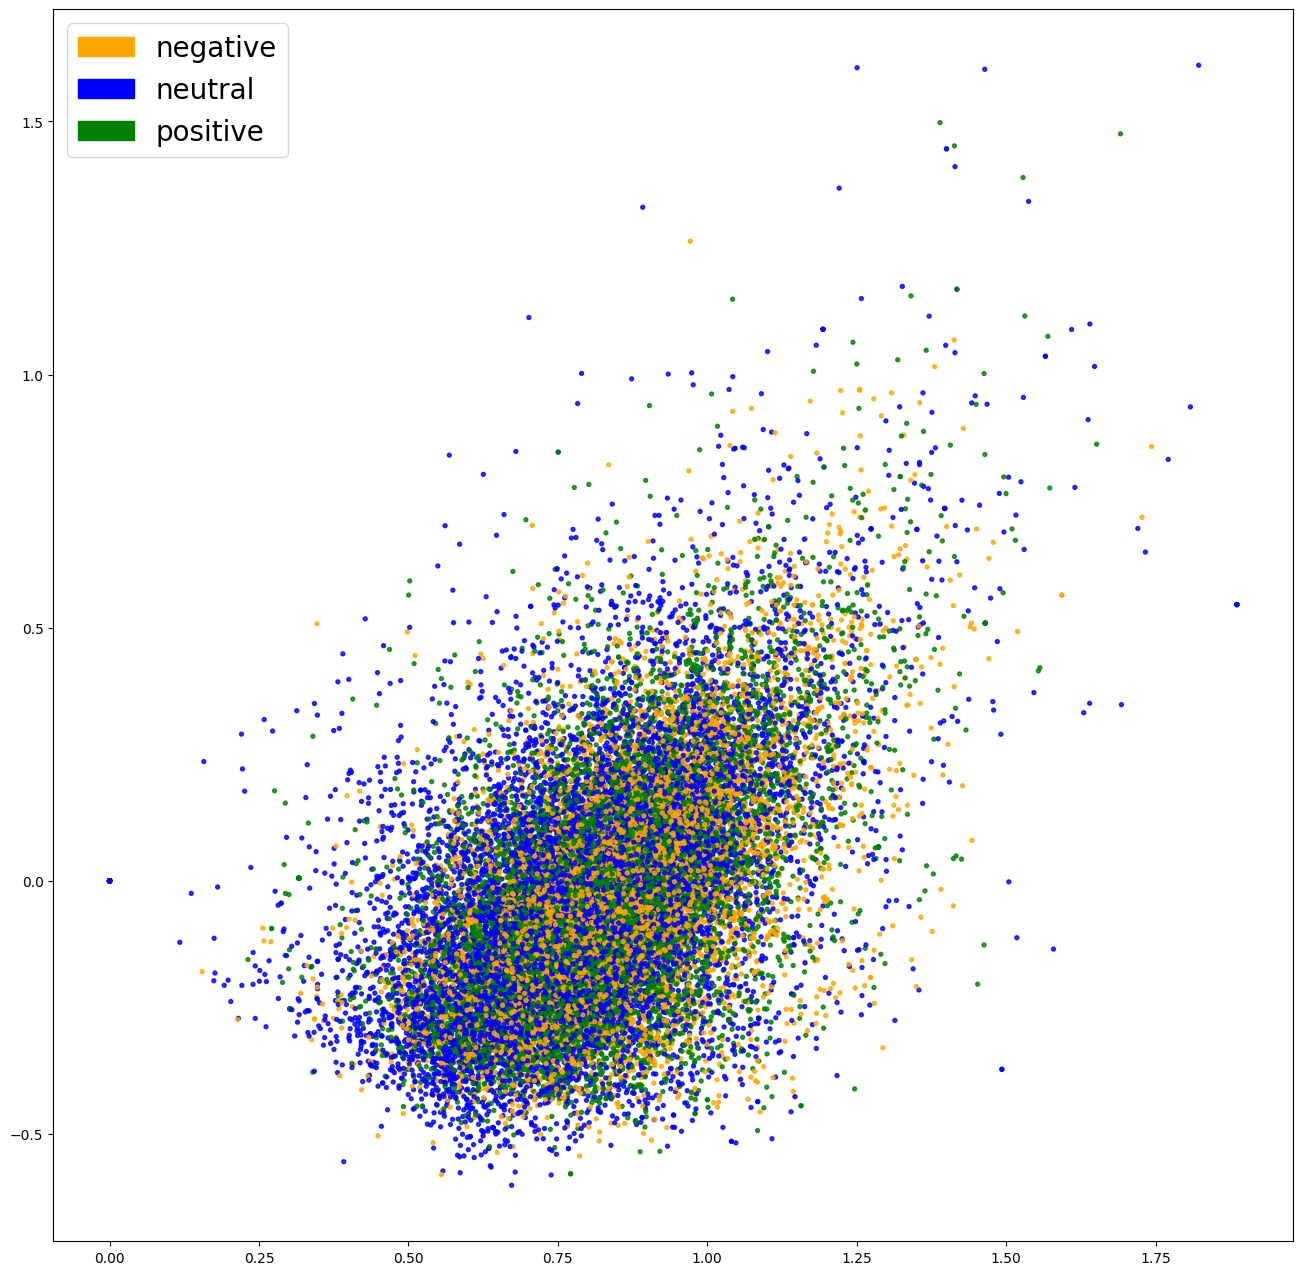

In [ ]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(embeddings, list_labels)
plt.show()

Также не получилось разделить

## Классификация

In [ ]:
from sklearn.model_selection import GridSearchCV

# Выбираем наилучшие параметры
param_grid = {
    'C': [0.1, 1, 10, 30],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'multi_class': ['ovr', 'multinomial']
}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=12), param_grid, cv=5)
grid.fit(X_train_word2vec, y_train_word2vec)
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 1, 'multi_class': 'ovr', 'solver': 'liblinear'}


In [ ]:
clf_w2v = LogisticRegression(C=1, class_weight='balanced', solver='liblinear',
                         multi_class='ovr', random_state=12)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

## Метрики

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec))

accuracy = 0.671, precision = 0.672, recall = 0.671, f1 = 0.671, r2 = 0.216


Метрики получились даже хуже

## Матрица ошибок

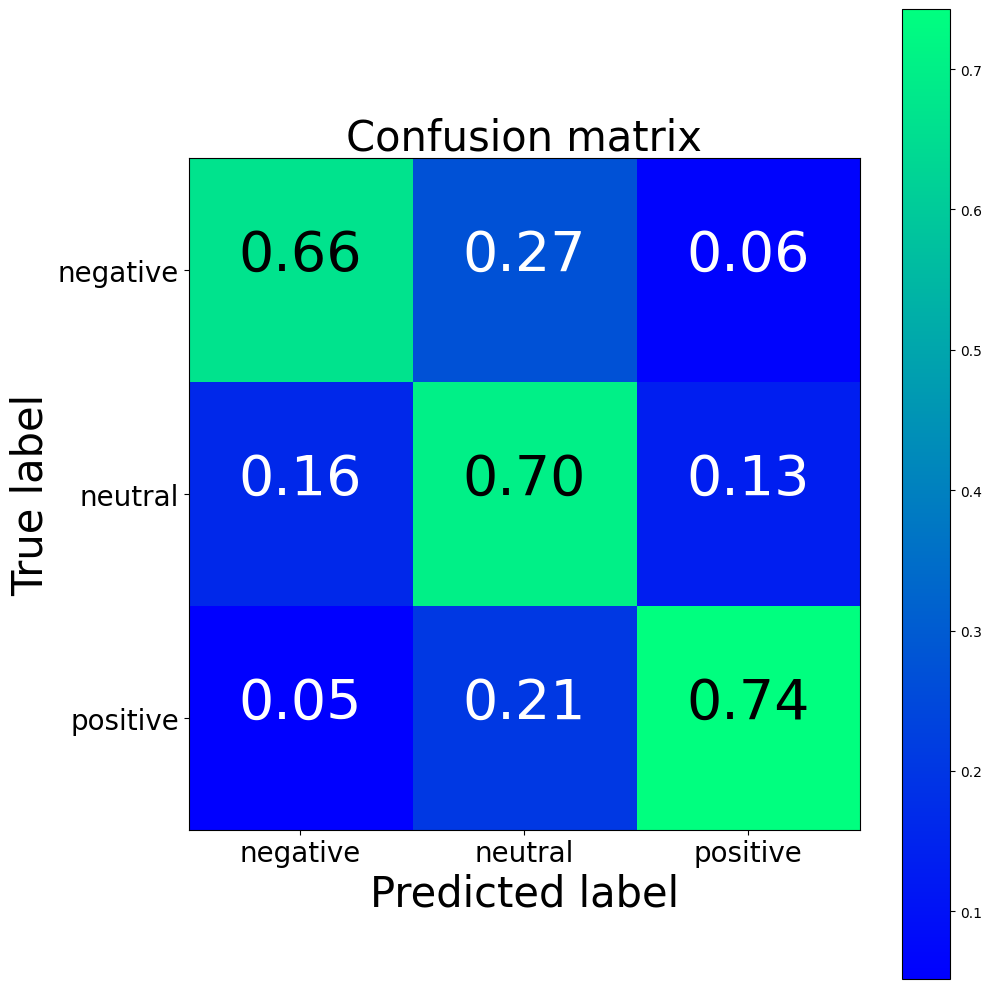

Word2Vec confusion matrix
[[1015  427  123]
 [ 384 1496  353]
 [ 126  395 1178]]
TFIDF confusion matrix
[[1039  435   91]
 [ 370 1559  304]
 [  79  372 1248]]
BoW confusion matrix
[[1040  429   96]
 [ 365 1567  301]
 [  88  349 1262]]


In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['negative','neutral','positive'], normalize=True, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Матрица также подтверждает, что модель работает хуже.

Это может быть связано с различными тематиками, используемыми для обучения (новости и окрас текста).

Также, возможно, модель использует более сложные зависимости, которые не видно при логистической регрессии

# Интерпретация модели при помощи LIME

LIME доступен на Github в виде открытого пакета. Данный интерпретатор, работающий по принципу черного ящика, позволяет пользователям объяснять решения любого классификатора на одном конкретном примере при помощи изменения ввода (в нашем случае — удаления слова из предложения) и наблюдения за тем, как изменяется предсказание.

In [ ]:
!pip install lime

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

# Разделяем список текстов
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=12)
# Загруженная раннее модель
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    # Токенизация
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        # Усреднённое представление векторов
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

# Последовательная трансформация модели
#c = make_pipeline(count_vectorizer, clf)

## Применяем LIME для нашей модели

In [ ]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ['negative','neutral','positive']):

    exp = explain_one_instance(features[index], class_names = class_names)
    # Выводим индекс записи и настоящий класс
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [ ]:
visualize_one_exp(X_test_data, y_test_data, 62)

Index: 62
True class: neutral


In [ ]:
visualize_one_exp(X_test_data, y_test_data, 80)

Index: 80
True class: positive


LIME может визуально объяснить, почему текст был отнесён к тому или иному классу.

Используем LIME на репрезентативной выборке тестовых данных и посмотрим частоту встречаемости слов.

In [ ]:
import random
from collections import defaultdict

random.seed(12)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    # Случайная выборка из test_set
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()

    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict) # Веса слов

    # Объяснение каждого текста с помощью LIME
    for sentence in sample_sentences:
        # Усреднение векторов
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        # Список наиболее значимых слов
        listed_explanation = exp.as_list(label=curr_label)

        # Агрегация данных(сохранение влияния слов на предсказание класса)
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]

    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        # Средние веса
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        # Отрицательно влияющие слова
        detractors = average_contributions[curr_label].sort_values()
        # Поддерживающие слова
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        # Добавление в словарь
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

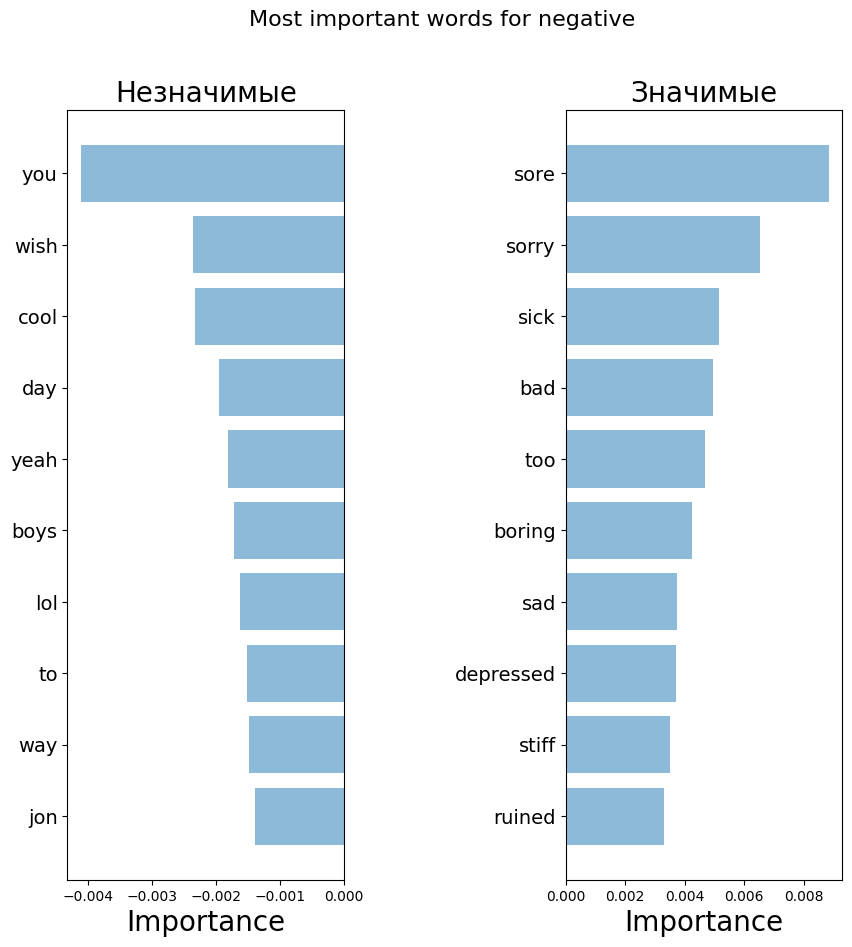

In [ ]:
# Выводим первые 10 значимых и 10 незначимых слов
top_words = sorted_contributions['negative']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['negative']['supporters'][:10].tolist()
bottom_words = sorted_contributions['negative']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['negative']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for negative")

Теперь наша модель в незначимых словах указывает слова, не имеющие окраса (в большинстве случаях). В значимых - похожие слова, как и в предыдущих моделях

# Модель: Свёрточные нейронные сети (CNN)

Сверточные нейронные сети для классификации предложений (CNNs for Sentence Classification) обучаются очень быстро и могут сослужить отличную службу в качестве входного уровня в архитектуре глубокого обучения. Несмотря на то, что сверточные нейронные сети (CNN) в основном известны своей высокой производительностью на данных-изображениях, они показывают превосходные результаты при работе с текстовыми данными, и обычно гораздо быстрее обучаются, чем большинство сложных подходов NLP (например, LSTM-сети и архитектуры Encoder/Decoder ). Эта модель сохраняет порядок слов и обучается ценной информации о том, какие последовательности слов служат предсказанием наших целевых классов. В отличии от предыдущих моделей, она в курсе существования разницы между фразами «Лёша ест растения» и «Растения едят Лёшу».

## Преобразуем данные в векторное представление

In [ ]:
from tensorflow.keras.preprocessing.text  import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300 # Размер эмбендингов
MAX_SEQUENCE_LENGTH = 35 # Максимальная длина последовательности
VOCAB_SIZE = len(VOCAB) # Размер словаря

VALIDATION_SPLIT=.2 # Доля данных для валидации
# Токенизатор
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
# Обучение токенизатора не текстах
tokenizer.fit_on_texts(clean_questions["text"].tolist())
# Преобразование текста в последовательность индексов
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

# Словарь, где каждое слово - индекс
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Выравнивание до максимальной длины
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# Метки классов
labels = to_categorical(np.asarray(clean_questions["sentiment"]))

# Перемешивание данных
indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
# Деление на валидацию и тренировку
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

# Создание эмбендингов(матрица, где строки - индексы слов, столбцы - значения эмбендингов для этих слов)
embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
# если слова нет в word2vec, то генерируем случайный вектор
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 26597 unique tokens.
(26598, 300)


## Собираем простейшую CNN

In [ ]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

# Нейронка CNN
# max_sequence_length - размерность входа
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):

    # Слой Embedding
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Свёрточные слои
    convs = []
    filter_sizes = [3,4,5]
    # Для каждого размера создаются свёртки с 128 фильтрами
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    # Объединение результатов свёрток и подвыборок
    l_merge = Concatenate(axis=1)(convs)

    # Дополнительная одноразмерная свёртка
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    # Подвыборка для сокращения размерности
    pool = MaxPooling1D(pool_size=3)(conv)

    # Случайным образом отключаем 50% нейронов для предотвращения переобучения
    if extra_conv==True:
        x = Dropout(0.5)(l_merge)
    else:
        x = Dropout(0.5)(pool)
    # Преобразование в одномерный вектор
    x = Flatten()(x)
    # Полносвязный слой с 128 нейронами и функцией активации ReLU
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    # Выходной слой - вероятности каждого класса
    preds = Dense(labels_index, activation='softmax')(x)

    # Создание модели и компиляция
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

## Разбиваеи на обучающую и тестовую выборки

In [ ]:
# Разбиение на тренировочную и валидационную выборки
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

# Компиляция модели
model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM,
                len(list(clean_questions["sentiment"].unique())), False)

## Обучаем модель

Применяем callback чтобы не переобучить модель

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=128, callbacks=[early_stopping])

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 43s 237ms/step - acc: 0.4331 - loss: 1.0627 - val_acc: 0.6503 - val_loss: 0.7784
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - acc: 0.6682 - loss: 0.7557 - val_acc: 0.6991 - val_loss: 0.6898
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - acc: 0.7216 - loss: 0.6603 - val_acc: 0.7061 - val_loss: 0.6814
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - acc: 0.7513 - loss: 0.5982 - val_acc: 0.7089 - val_loss: 0.6877
Epoch 5/50
 96/172 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - acc: 0.7964 - loss: 0.4992

## Выполняем предсказание и выводим метрики

In [ ]:
y_pred = model.predict(x_val)

172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step


In [ ]:
y_pred_cnn = np.argmax(y_pred, axis=1)
y_val_cnn = np.argmax(y_val, axis=1)

In [ ]:
y_val_cnn

array([1, 0, 1, ..., 1, 0, 2])

In [ ]:
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn = get_metrics(y_val_cnn, y_pred_cnn)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn))

accuracy = 0.714, precision = 0.713, recall = 0.714, f1 = 0.713, r2 = 0.359


Метрики получились чуть лучше, чем в предыдущих моделях

## Матрица ошибок

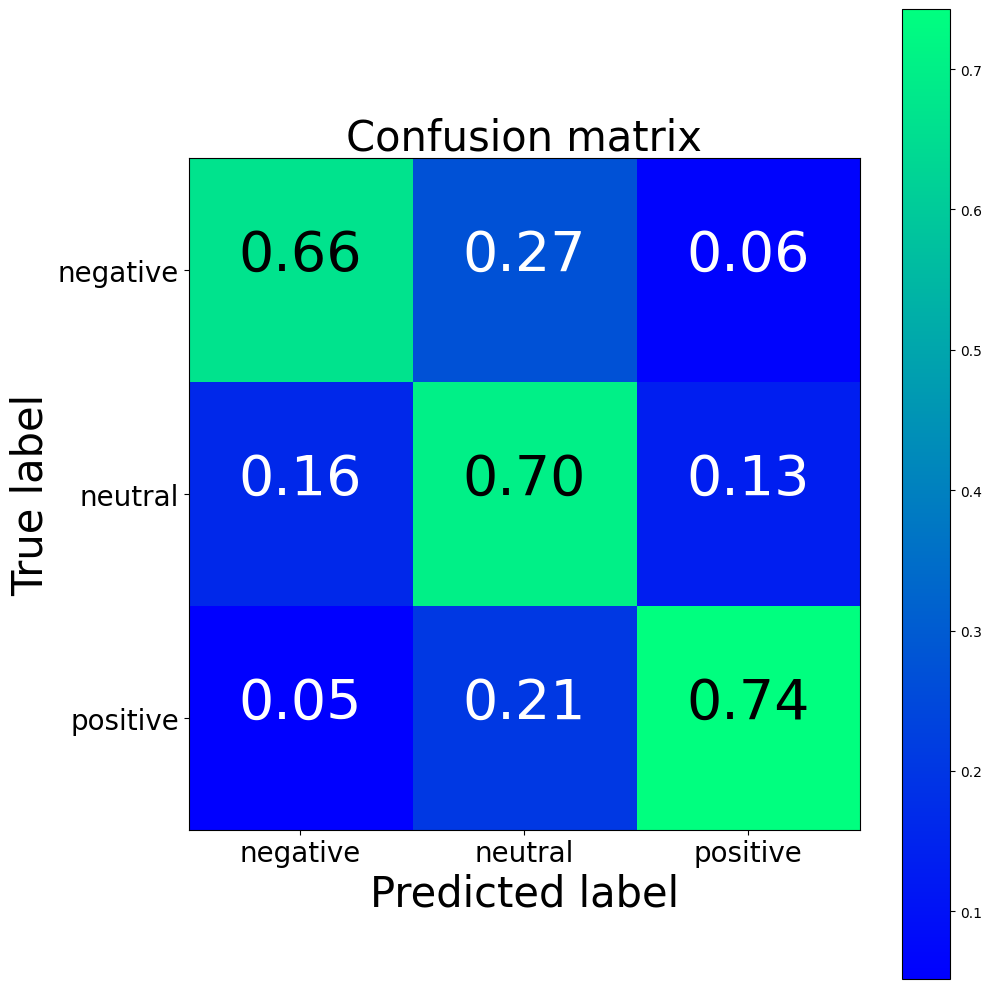

CNN confusion matrix
[[1109  386   99]
 [ 356 1502  376]
 [  73  284 1311]]
Word2Vec confusion matrix
[[1015  427  123]
 [ 384 1496  353]
 [ 126  395 1178]]
TFIDF confusion matrix
[[1039  435   91]
 [ 370 1559  304]
 [  79  372 1248]]
BoW confusion matrix
[[1040  429   96]
 [ 365 1567  301]
 [  88  349 1262]]


In [ ]:
cm_cnn = confusion_matrix(y_val_cnn, y_pred_cnn)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['negative','neutral','positive'], normalize=True, title='Confusion matrix')
plt.show()

print("CNN confusion matrix")
print(cm_cnn)
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Это явно лучшее, что у нас получилось!

# Выводы

Самой лучшей моделью для определения окраса сообщения оказалась CNN.

При этом "Мешок слов" при своей простоте показывает результаты не намного хуже, чем CNN.